### Generic RNNs for forecasting periodic, univariate time-series
In this notebook, we'll walk through a simple example using RNNs in Pytorch to forecast sine waves (with middling to poor success)

Link to colab: https://colab.research.google.com/drive/10-FpzKl5mf7UejimUWziqcGMRrSHMpHD?usp=sharing

In [1]:
### necessary imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

We start by generating training data. We simulate 500 instances of $x_i (t) = \cos \omega_i t$ with each $\omega_i \sim \mathcal U (\pi, 3\pi)$. 

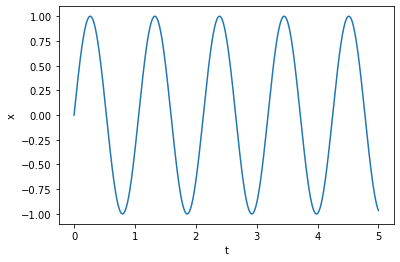

In [2]:
t = np.linspace(start=0, stop=5, num=1000)
lookback = 50
train_sims = np.zeros((500,1000,1))
for i in range(len(train_sims)):
    train_sims[i] = np.sin(np.random.uniform(np.pi, 3*np.pi) * t).reshape(-1,1)

train_data_in = np.zeros((480*500, lookback, 1))
train_data_out = np.zeros((480*500, 1))
for i in range(500):
    temp_in = np.zeros((480, lookback, 1))
    temp_out = np.zeros((480,1))
    for j in range(480):
        temp_in[j] = train_sims[i, j:j+lookback]
        temp_out[j] = train_sims[i, j+lookback]
    train_data_in[(i)*480:(i+1)*480] = temp_in
    train_data_out[(i)*480:(i+1)*480] = temp_out

### plot example trajectory
plt.plot(t, train_sims[0, :, :])
plt.xlabel('t')
plt.ylabel('x')
plt.show()

An easy way of training networks in Pytorch involves the creation of torch datasets. These datasets cleanly store input output pairs. In our case, we'd like to use a trajectory of measurements to forecast one step in the future. That is, we'll use $\{x_1, \dots x_k\}$ (input) to forecast $x_{k+1}$ (output).

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.len
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = TimeSeriesDataset(torch.tensor(train_data_in, dtype=torch.float32).to(device),
                                  torch.tensor(train_data_out, dtype=torch.float32).to(device))


We'll now make the recurrent model in Pytorch. The model will consist of a single, generic RNN layer followed by two linear layers.

In [9]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.rnn = torch.nn.RNNCell(input_size, hidden_size)
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size = x.shape[0]
        h_0 = torch.zeros(batch_size, self.hidden_size)
        if next(self.parameters()).is_cuda:
            h_0 = h_0.cuda()

        ### here is the for loop that captures the recurrence
        for i in range(x.shape[1]):
            h_0 = self.rnn(x[:, i, :], h_0)
        output = self.linear1(h_0)
        output = torch.nn.functional.relu(output)
        output = self.linear2(output)
        return output

rnn_model = RNN(1, 64).to(device)

Now we write a (very) bare bones training loop for the RNN model.

In [10]:
batch_size = 64
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
### data loader object automatically handles batching for a Pytorch dataset
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
for epoch in range(4):
    for k, data in enumerate(train_loader):
            rnn_model.train()
            outputs = rnn_model(data[0])
            optimizer.zero_grad()
            loss = criterion(outputs, data[1])
            loss.backward()
            optimizer.step()
    print('Epoch ' + str(epoch))
    print("Error " + str(loss.item()))

Epoch 0
Error 1.0415634278615471e-05
Epoch 1
Error 4.317570528655779e-06
Epoch 2
Error 1.3992064396006754e-06
Epoch 3
Error 9.377056358061964e-07


To see how well our RNN model is working, we'll try to forecast the signal $\sin 2.5 \pi t$.

In [11]:
test_wave = np.sin(2.5*np.pi *t)
test_data_in = np.zeros((1000 - lookback, lookback, 1))
test_data_out = np.zeros((1000 - lookback,1))
for i in range(1000 - lookback):
    test_data_in[i] = test_wave[i:i+lookback].reshape(lookback,1)
    test_data_out[i] = test_wave[i+lookback]

test_data_in = torch.tensor(test_data_in,dtype=torch.float32)

In [12]:
### forecasting code adapted from https://github.com/ashesh6810/RCESN_spatio_temporal
rnn_model.to('cpu')
ypred = np.zeros((1000 - lookback, 1))

for i in range(test_data_in.shape[0]):
    if i ==0:
        inputs = test_data_in[0, -lookback:, :].reshape((1,lookback, 1)).cpu()
        ypred[i, :] = rnn_model(inputs).detach().numpy()

    elif i < lookback:
        inputs = test_data_in[i, -lookback:, :].reshape((1, lookback, 1)).cpu()
        temp = ypred[:i,:]
        inputs[0, (lookback - i):lookback, :] = torch.tensor(temp, dtype=torch.float32)
        ypred[i, :] = rnn_model(inputs).detach().numpy()

    else:
        inputs = torch.tensor(ypred[i - lookback:i,:].reshape((1, lookback, 1)), dtype=torch.float32)
        ypred[i, :] = rnn_model(inputs).detach().numpy()



Plot our forecast and the ground truth.

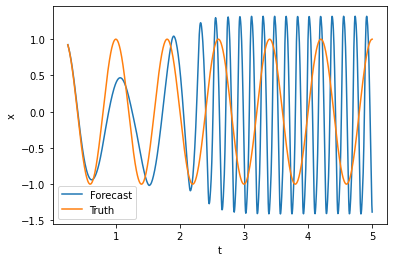

In [13]:
plt.plot(t[lookback:], ypred, label='Forecast')
plt.plot(t[lookback:], test_data_out, label='Truth')
plt.ylabel('x')
plt.xlabel('t')
plt.legend()
plt.show()

The forecast is generally bad, but reasonable in the short term. 
Questions for exploration:
1. This architecture was designed with hyperparameters chosen mostly randomly. Can you tune parameters to improve performance?
2. Can you improve the basic training loop provided to train the network faster? Improve performance? Revert to better performing parameters?
3. How does the network generalize beyond the range $\omega \in (\pi, 3\pi)?$
4. Try making the lookback parameter very long. You should find that past some length, the network will struggle to yield forecasts that are reasonable even in the very short term. This is the problem of "vanishing gradients." LSTMs are one way to address this issue.